# SAMPLING SIGNALS WITH FINITE RATE OF INNOVATION

In [2]:
# %% LOAD LIBRARIES

import os
import numpy as np

from matplotlib import style
from matplotlib import rcParams
from matplotlib import pyplot as plt

import fri_utils
import fri_algos

In [3]:
# %% PLOT SETTINGS

plt.style.use(['science','ieee'])

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["cm"],
    "mathtext.fontset": "cm",
    "font.size": 24})

os.makedirs('./../figures/vetterli_2001/', exist_ok=True)
path = './../figures/vetterli_2001/'

In [4]:
# %% GENERATE SIGNAL

np.random.seed(723)

K = 5                                                                       # Number of Diracs
TAU = 1                                                                     # Period of the signal

ak = np.sign(np.random.rand(K))*(1.0 + (np.random.randn(K) - 0.5)/1.0)      # Set amplitudes
tk = np.sort(np.random.rand(K)*TAU)                                         # Set shifts

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


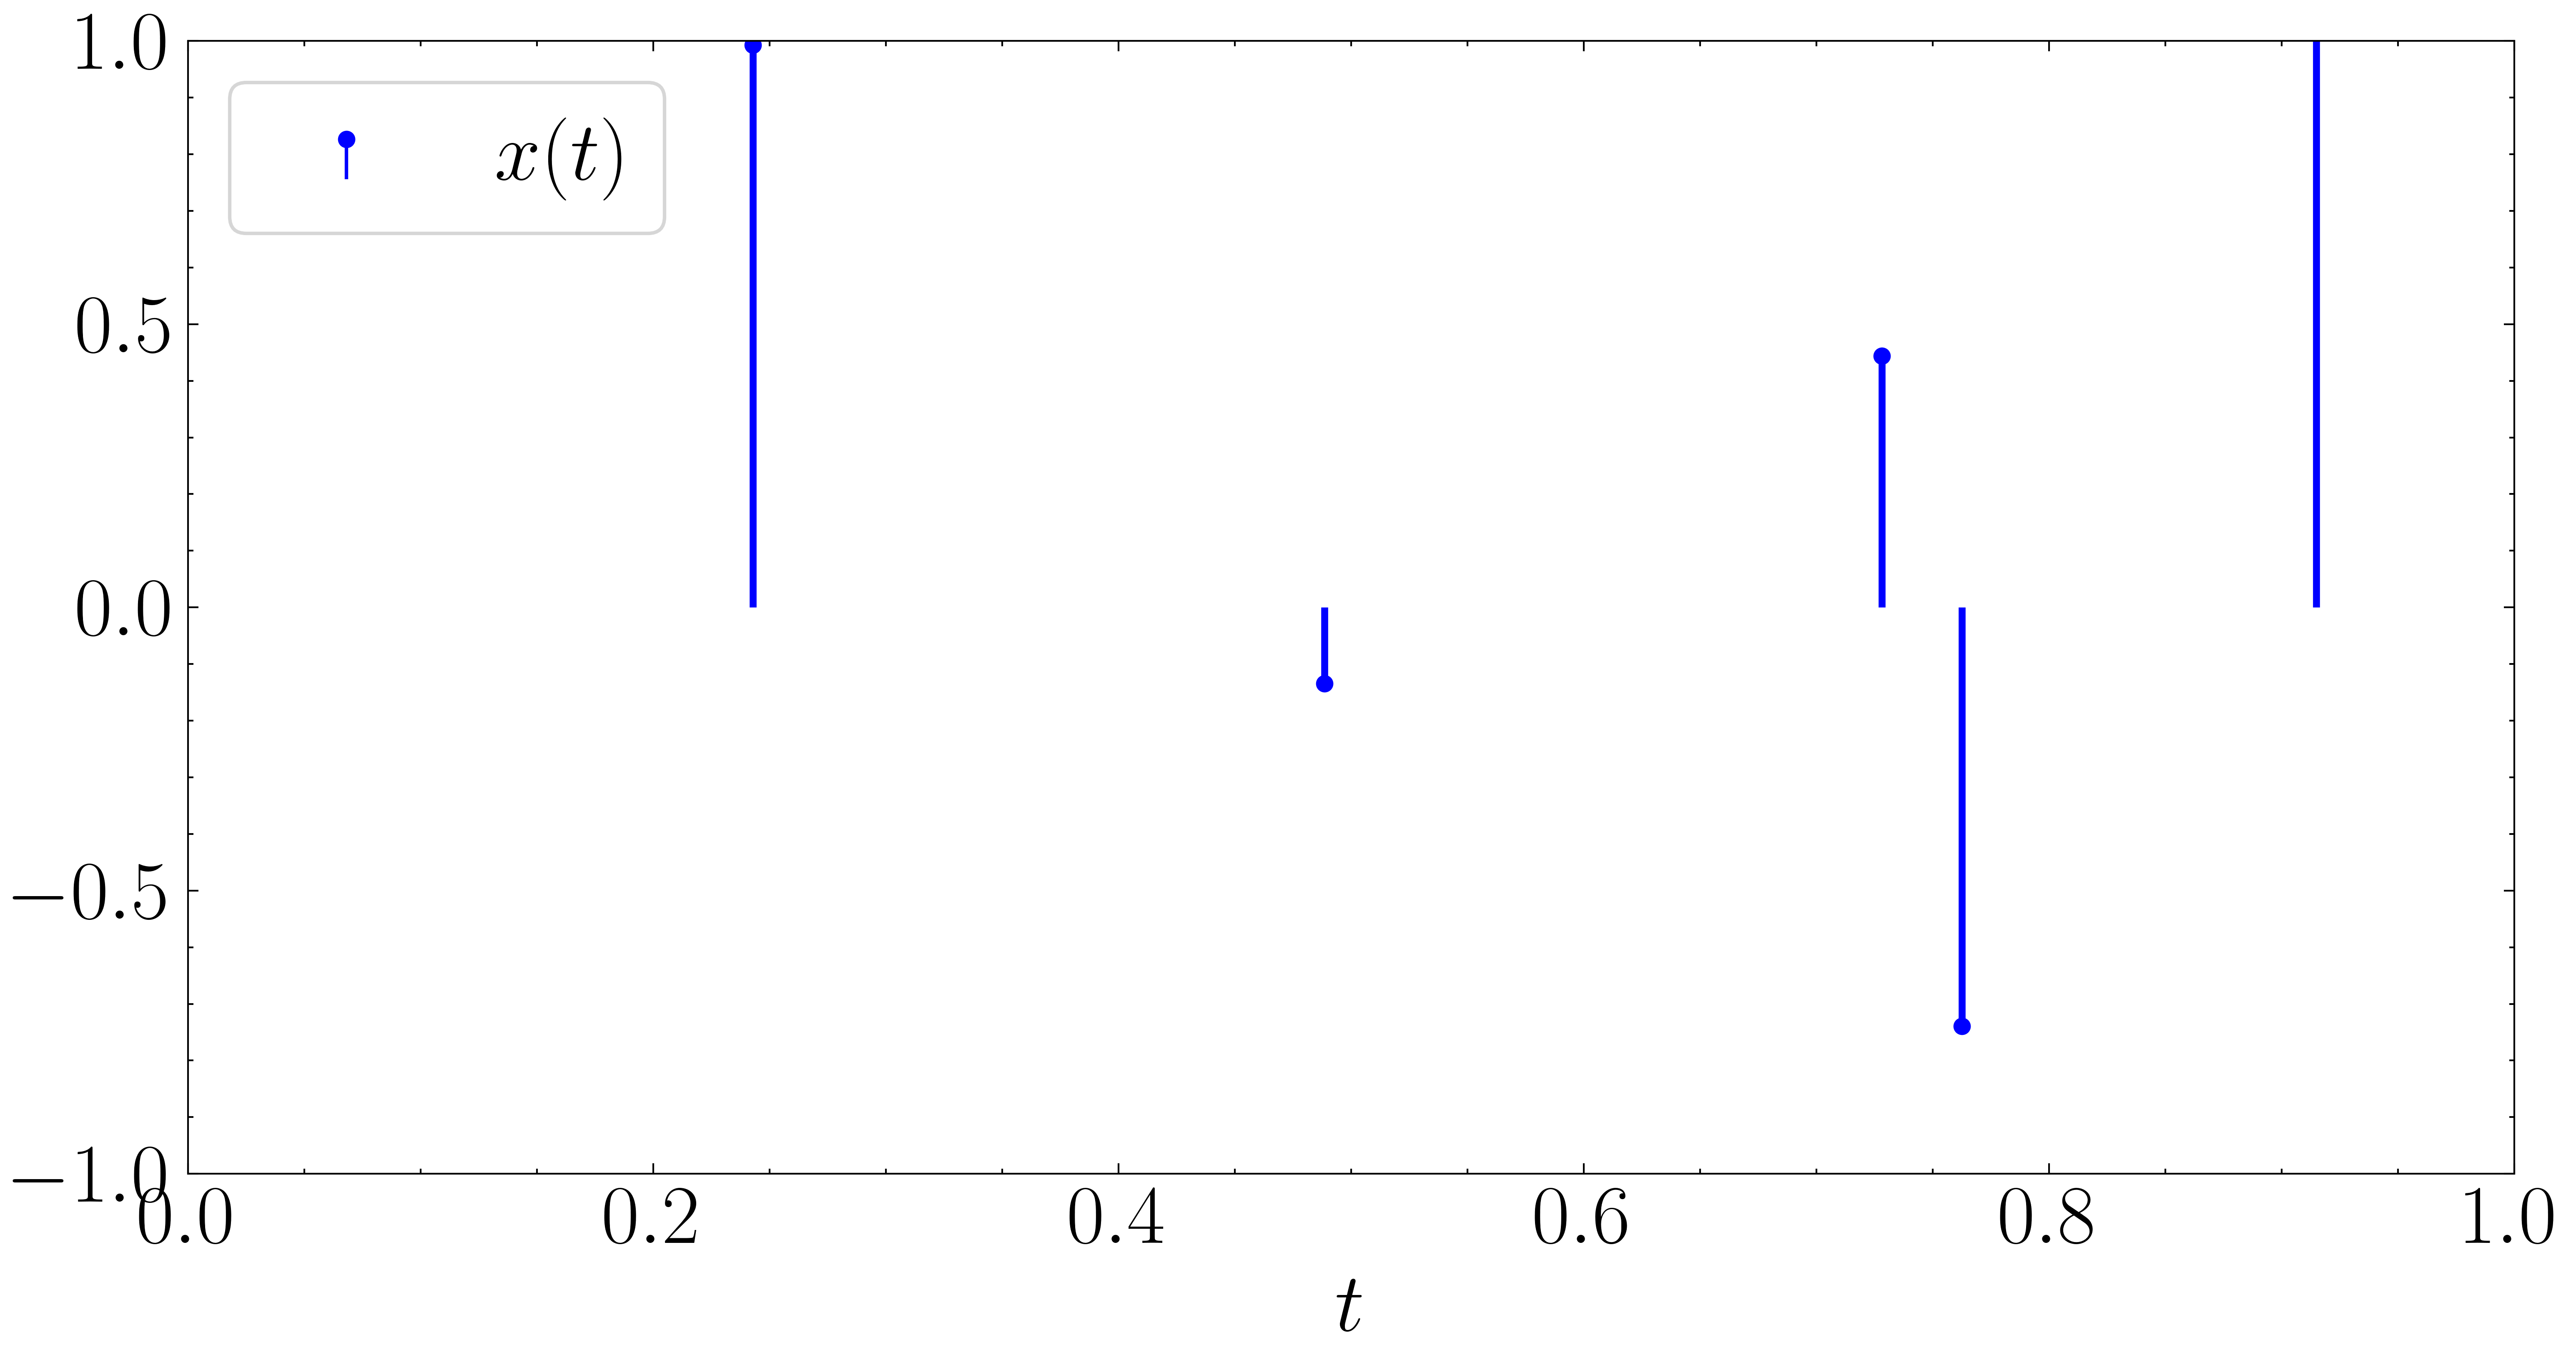

In [4]:
# %% PLOT ORIGINAL SIGNAL

fri_utils.plot_diracs(tk, ak, xaxis_label=r'$t$', legend_label=r'$x(t)$',
    xlimits=[0,TAU])

In [5]:
# %% KERNEL-BASED SAMPLING

# Define sampling parameters
M = K                           # Number of Fourier measurements
B = (2. * M + 1)/TAU            # Bandwidth of the Dirichlet kernel
N = 2 * M + 1                   # Number of temporal samples

# Filtered signal
t_continuous = np.linspace(0,TAU,1000)
tl_grid, tk_grid = np.meshgrid(tk, t_continuous)
filtered_signal = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

# Temporal samples
t_unif = np.arange(0, N, dtype=float)*TAU/N
tl_grid, tk_grid = np.meshgrid(tk, t_unif)
samples_unif = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


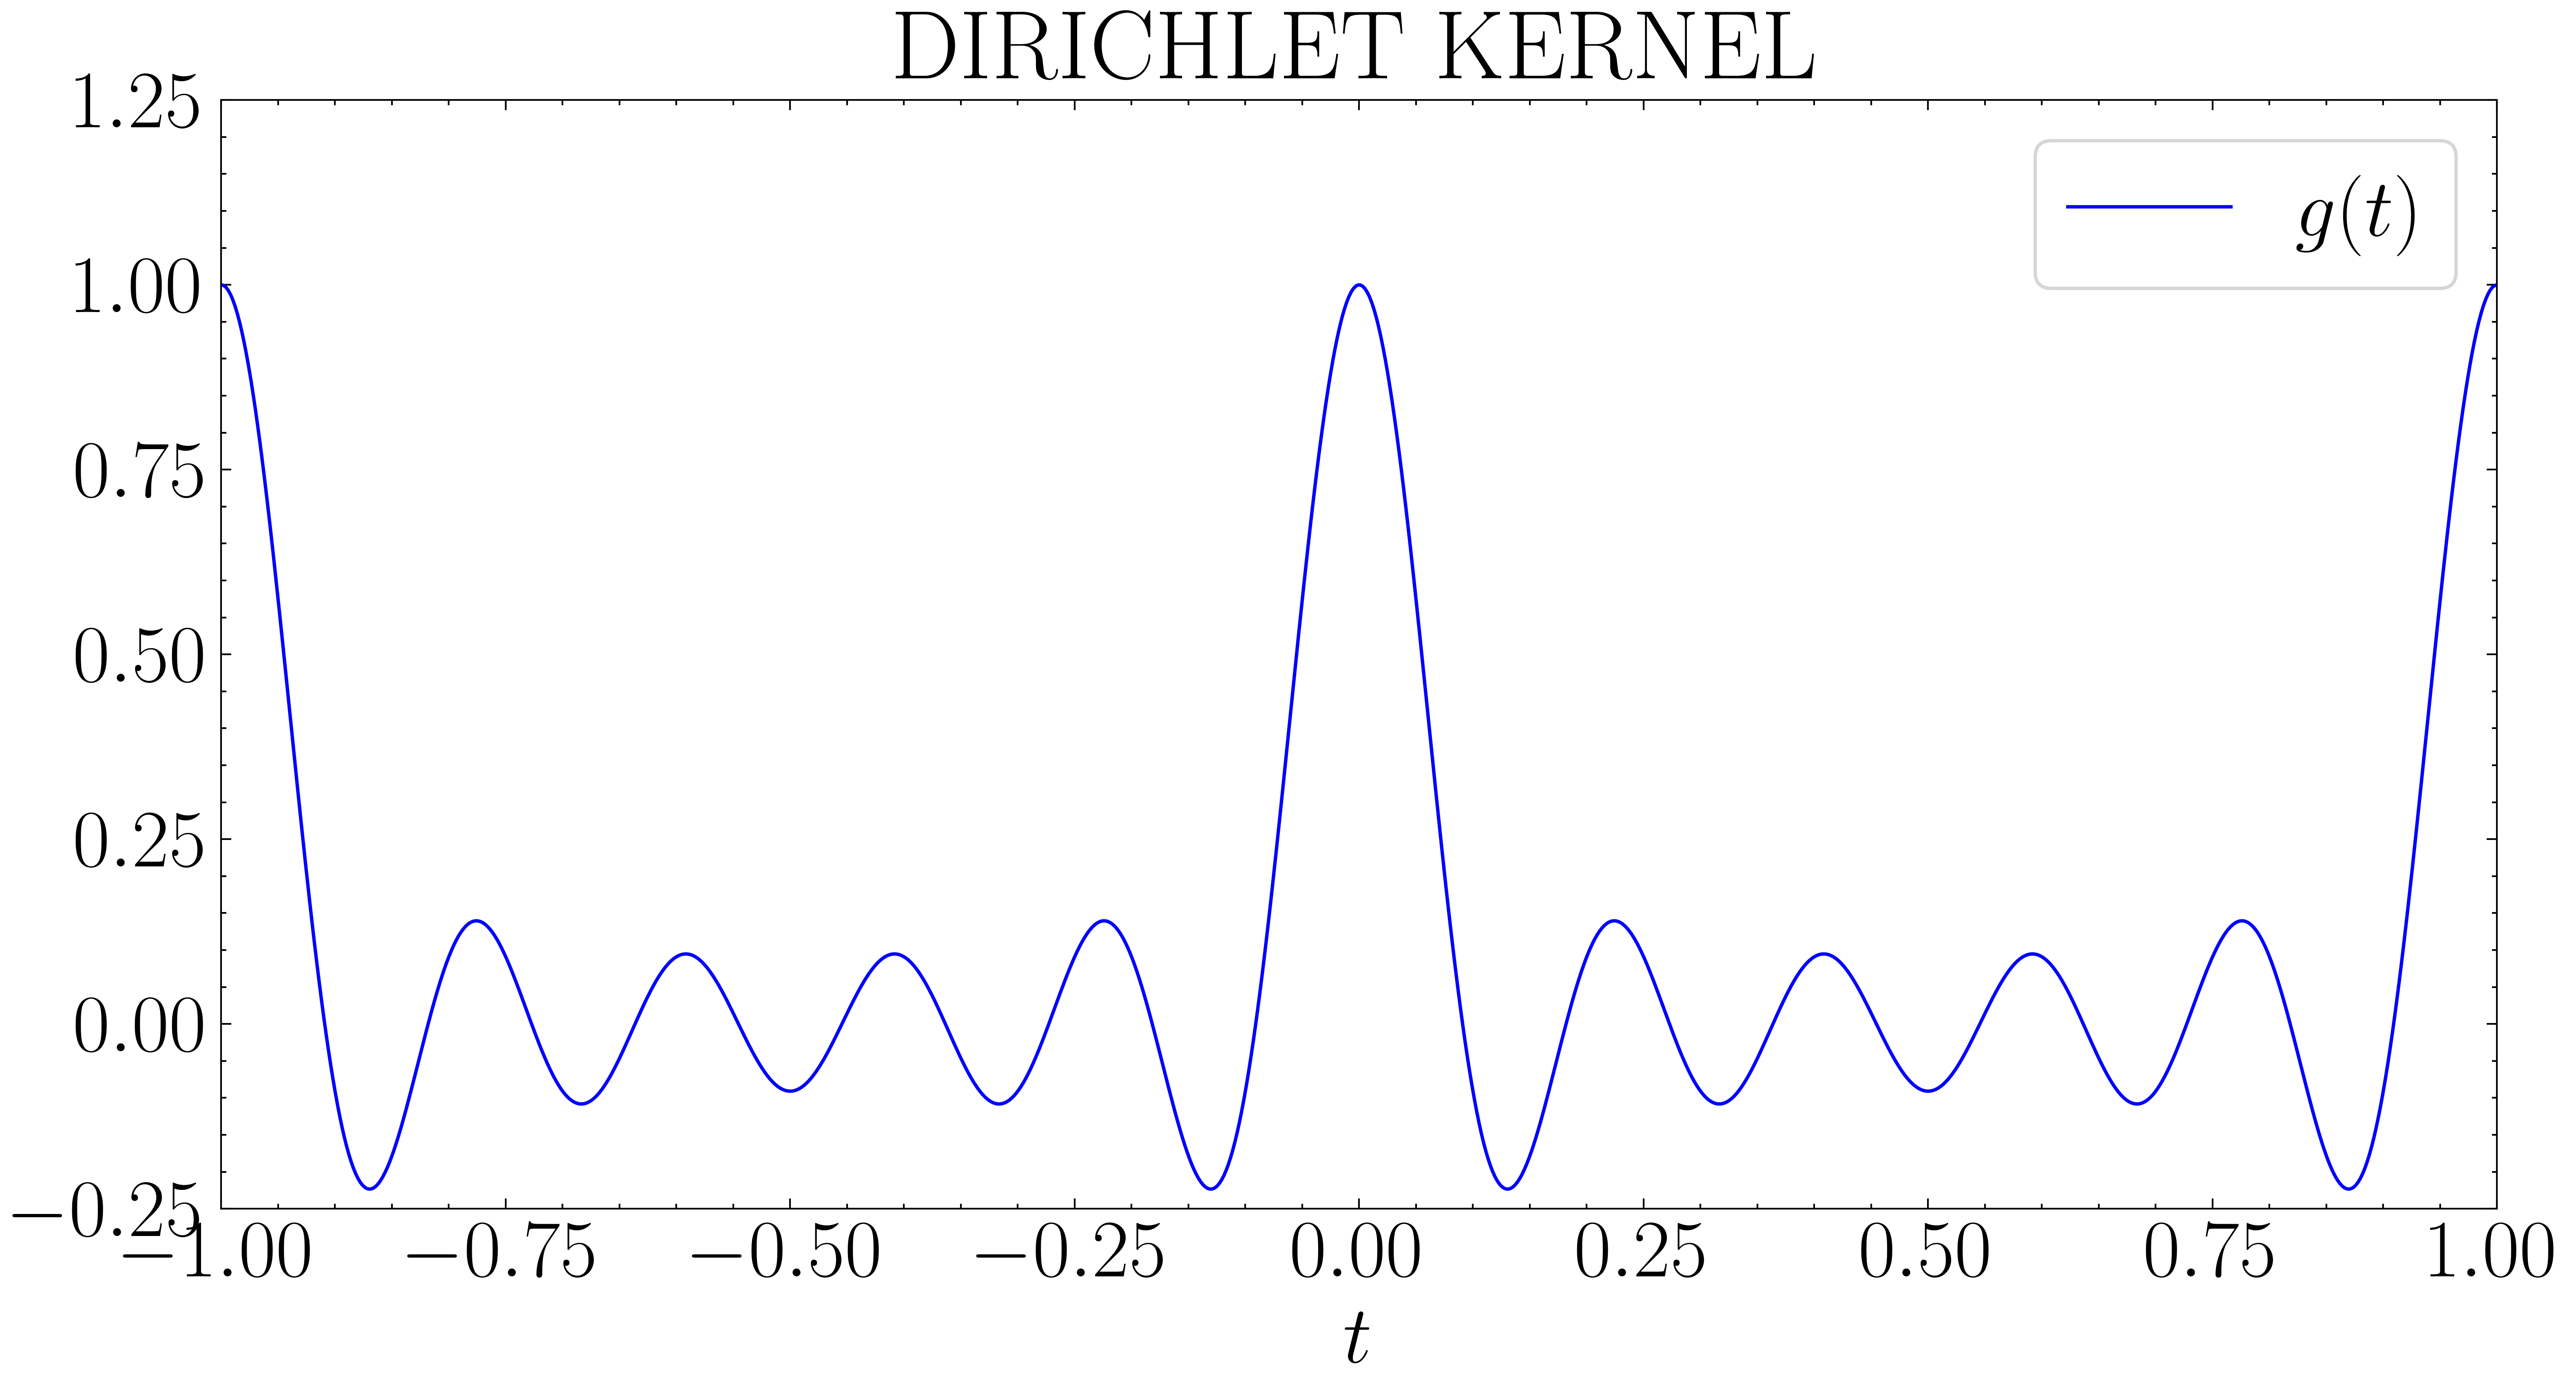

In [6]:
# %% PLOT SAMPLING KERNEL

fri_utils.plot_signal(np.linspace(-1,1,1000), fri_utils.dirichlet(np.linspace(-1,1,1000), B, TAU),
    legend_label=r'$g(t)$', xlimits=[-1,1], ylimits=[-.25,1.25],
    xaxis_label=r'$t$', title_text=r'DIRICHLET KERNEL',
    show=True, save=path+'dirichletKernel')

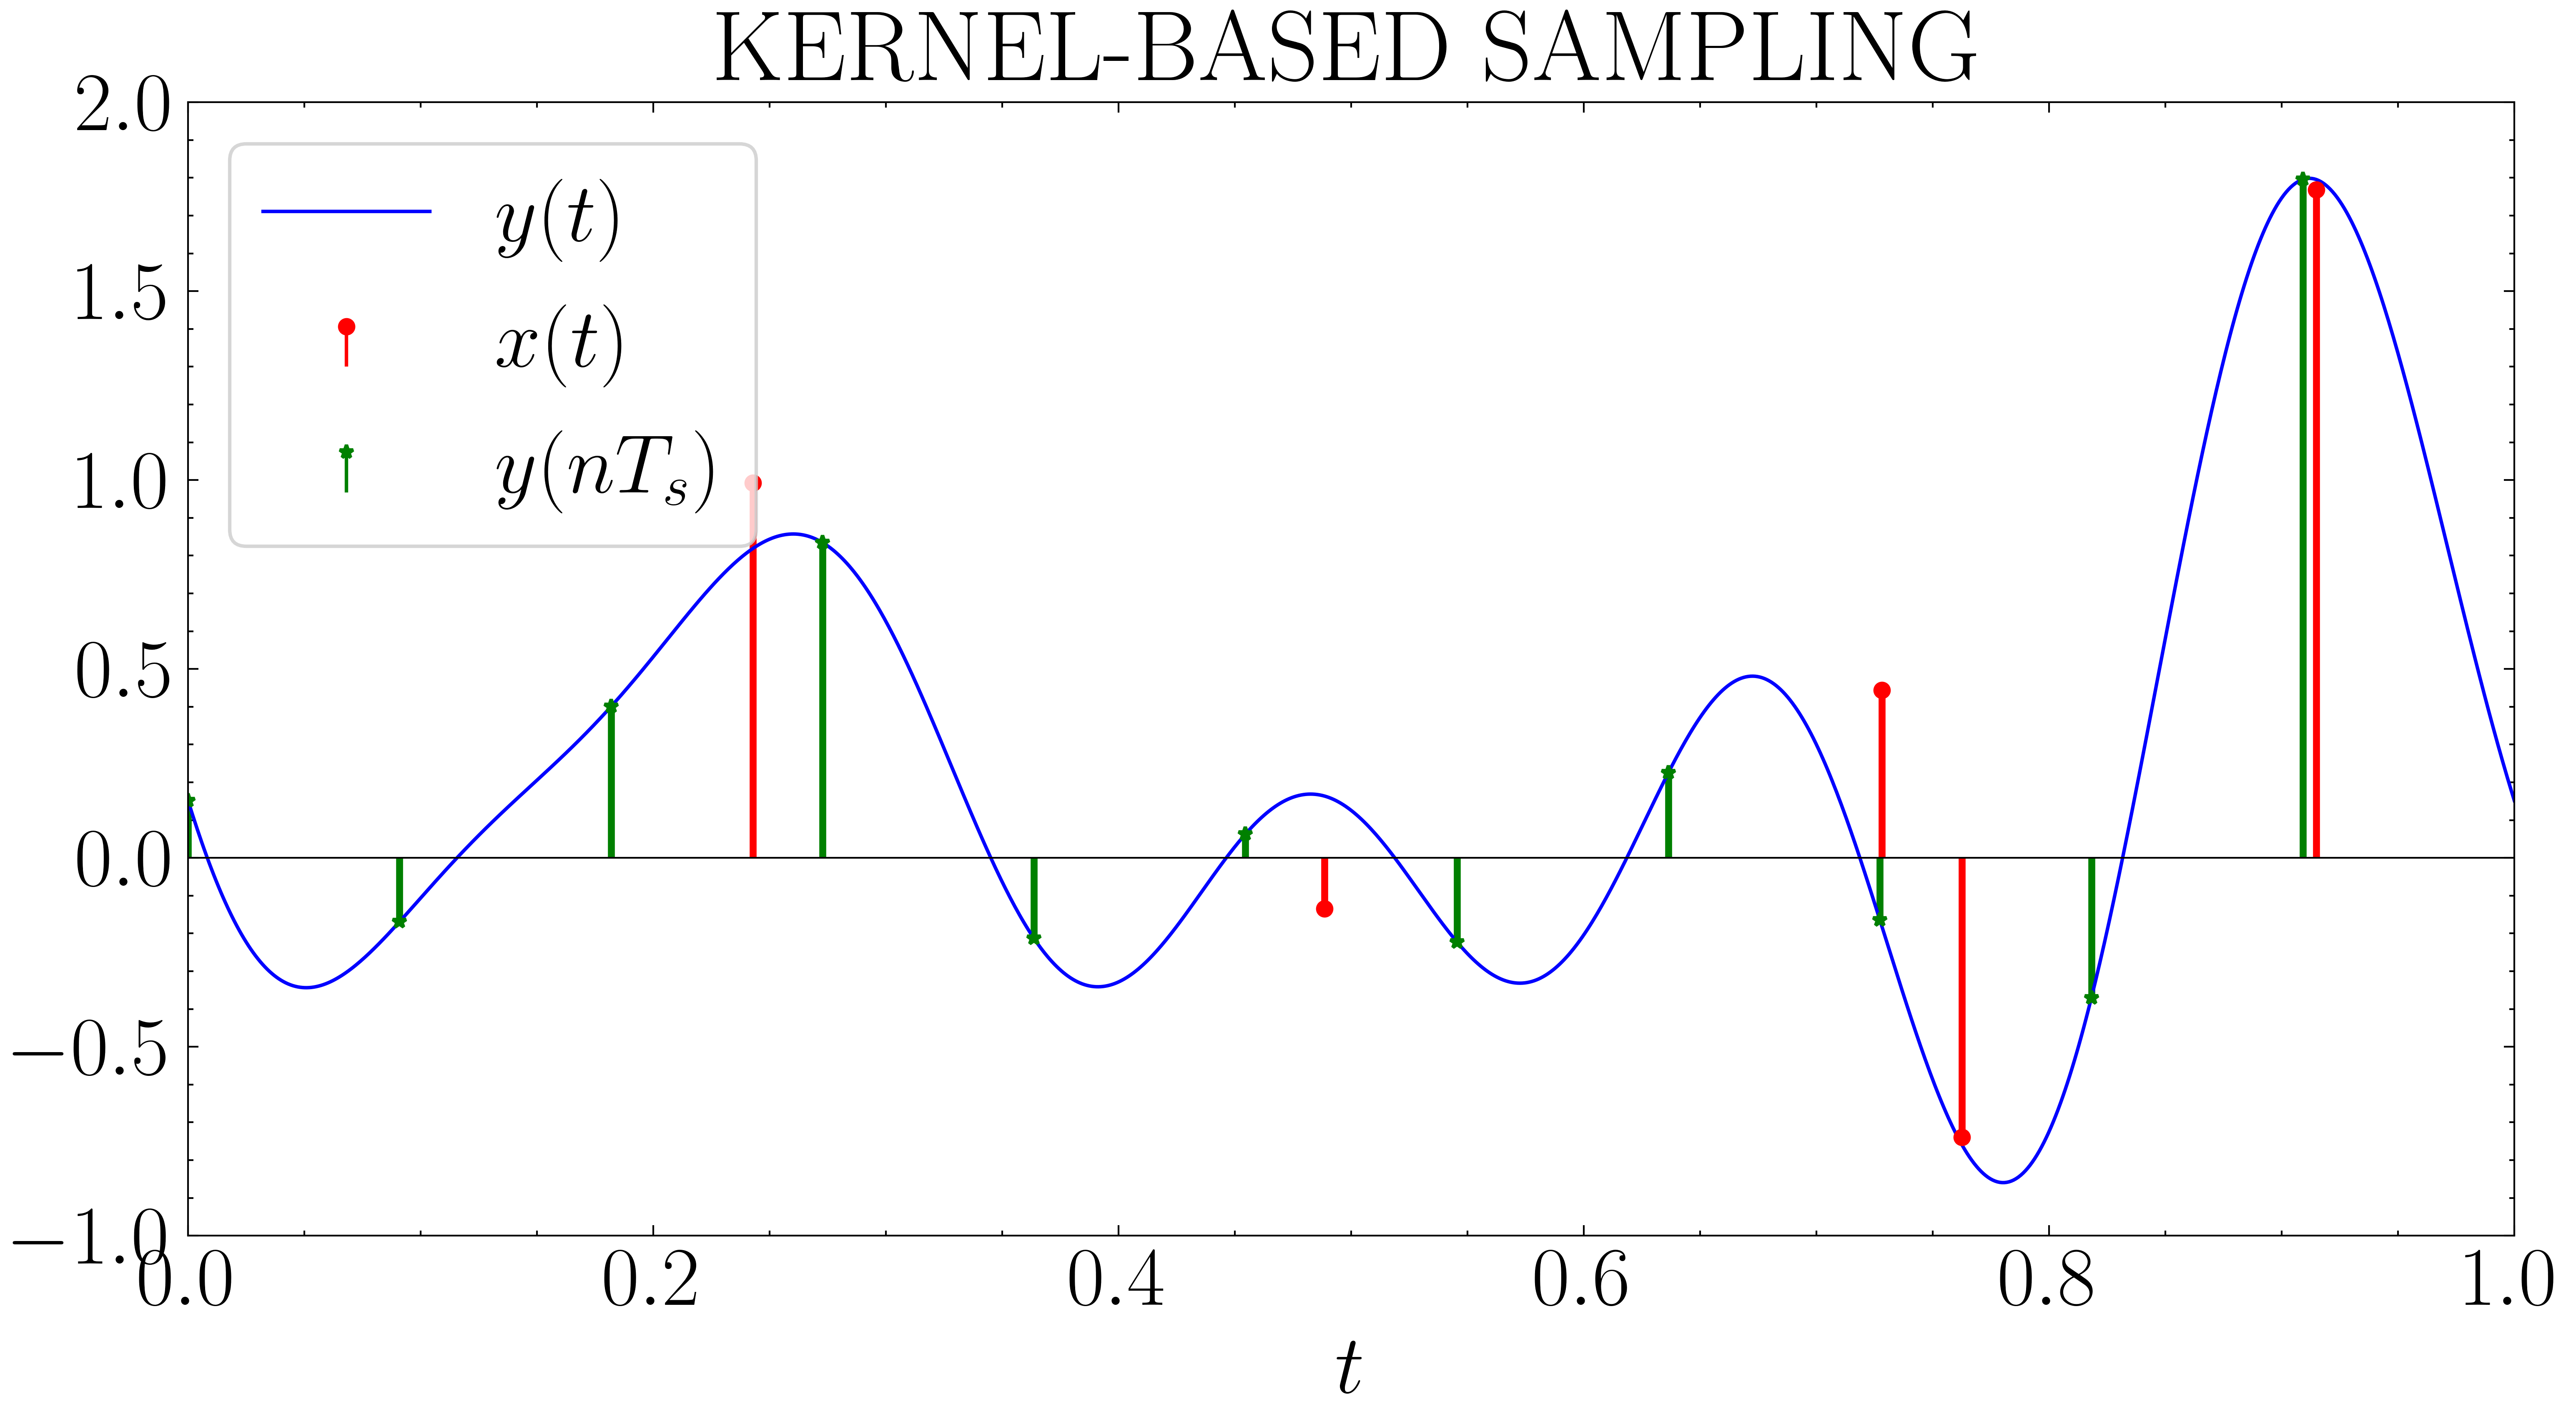

In [7]:
# %% PLOT SAMPLES

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_signal(t_continuous, filtered_signal, ax=ax, plot_colour='blue',
    legend_label=r'$y(t)$', show=False)
fri_utils.plot_signal(t_continuous, np.zeros(len(t_continuous)), ax=ax,
    plot_colour='black', line_width=0.5, show=False)
fri_utils.plot_diracs(tk, ak, ax=ax, plot_colour='red', legend_label=r'$x(t)$',
    show=False)
fri_utils.plot_diracs(t_unif, samples_unif, ax=ax, plot_colour='green',
    marker_style='*', legend_label=r'$y(nT_s)$', xaxis_label=r'$t$',
    title_text=r'KERNEL-BASED SAMPLING', xlimits=[0,TAU], ylimits=[-1,2],
    show=True, save=path+'sincUnifDiracSampling')

In [7]:
# %% SIGNAL RECOVERY

# Compute Fourier-series coefficients
forward_matrix = np.exp(1j*2*np.pi*np.outer(t_unif, np.arange(-K,K+1))/TAU)
fourier_series_coeffs = np.linalg.solve(forward_matrix, samples_unif)

# Estimate delays using Prony's method
annihilating_filter = fri_algos.prony_tls(fourier_series_coeffs, K)
tk_estimate = fri_algos.get_shifts(annihilating_filter, TAU)

# Estimate amplitudes using linear least-squares
swce_matrix = np.exp(-1j*2*np.pi*np.outer(np.arange(-K,K+1), tk_estimate)/TAU)
ak_estimate = N * np.matmul(np.linalg.pinv(swce_matrix),fourier_series_coeffs)

In [10]:
# %% COMPUTE ERRORS IN ESTIMATION

delay_estimation = np.linalg.norm(tk-tk_estimate)
amplitude_estimation = np.linalg.norm(ak-ak_estimate)

print(r'Total error in delay estimation: {0:.2e}'.format(delay_estimation))
print(r'Total error in amplitude estimation: {0:.2e}'.format(amplitude_estimation))

Total error in delay estimation: 6.48e-16
Total error in amplitude estimation: 7.54e-15


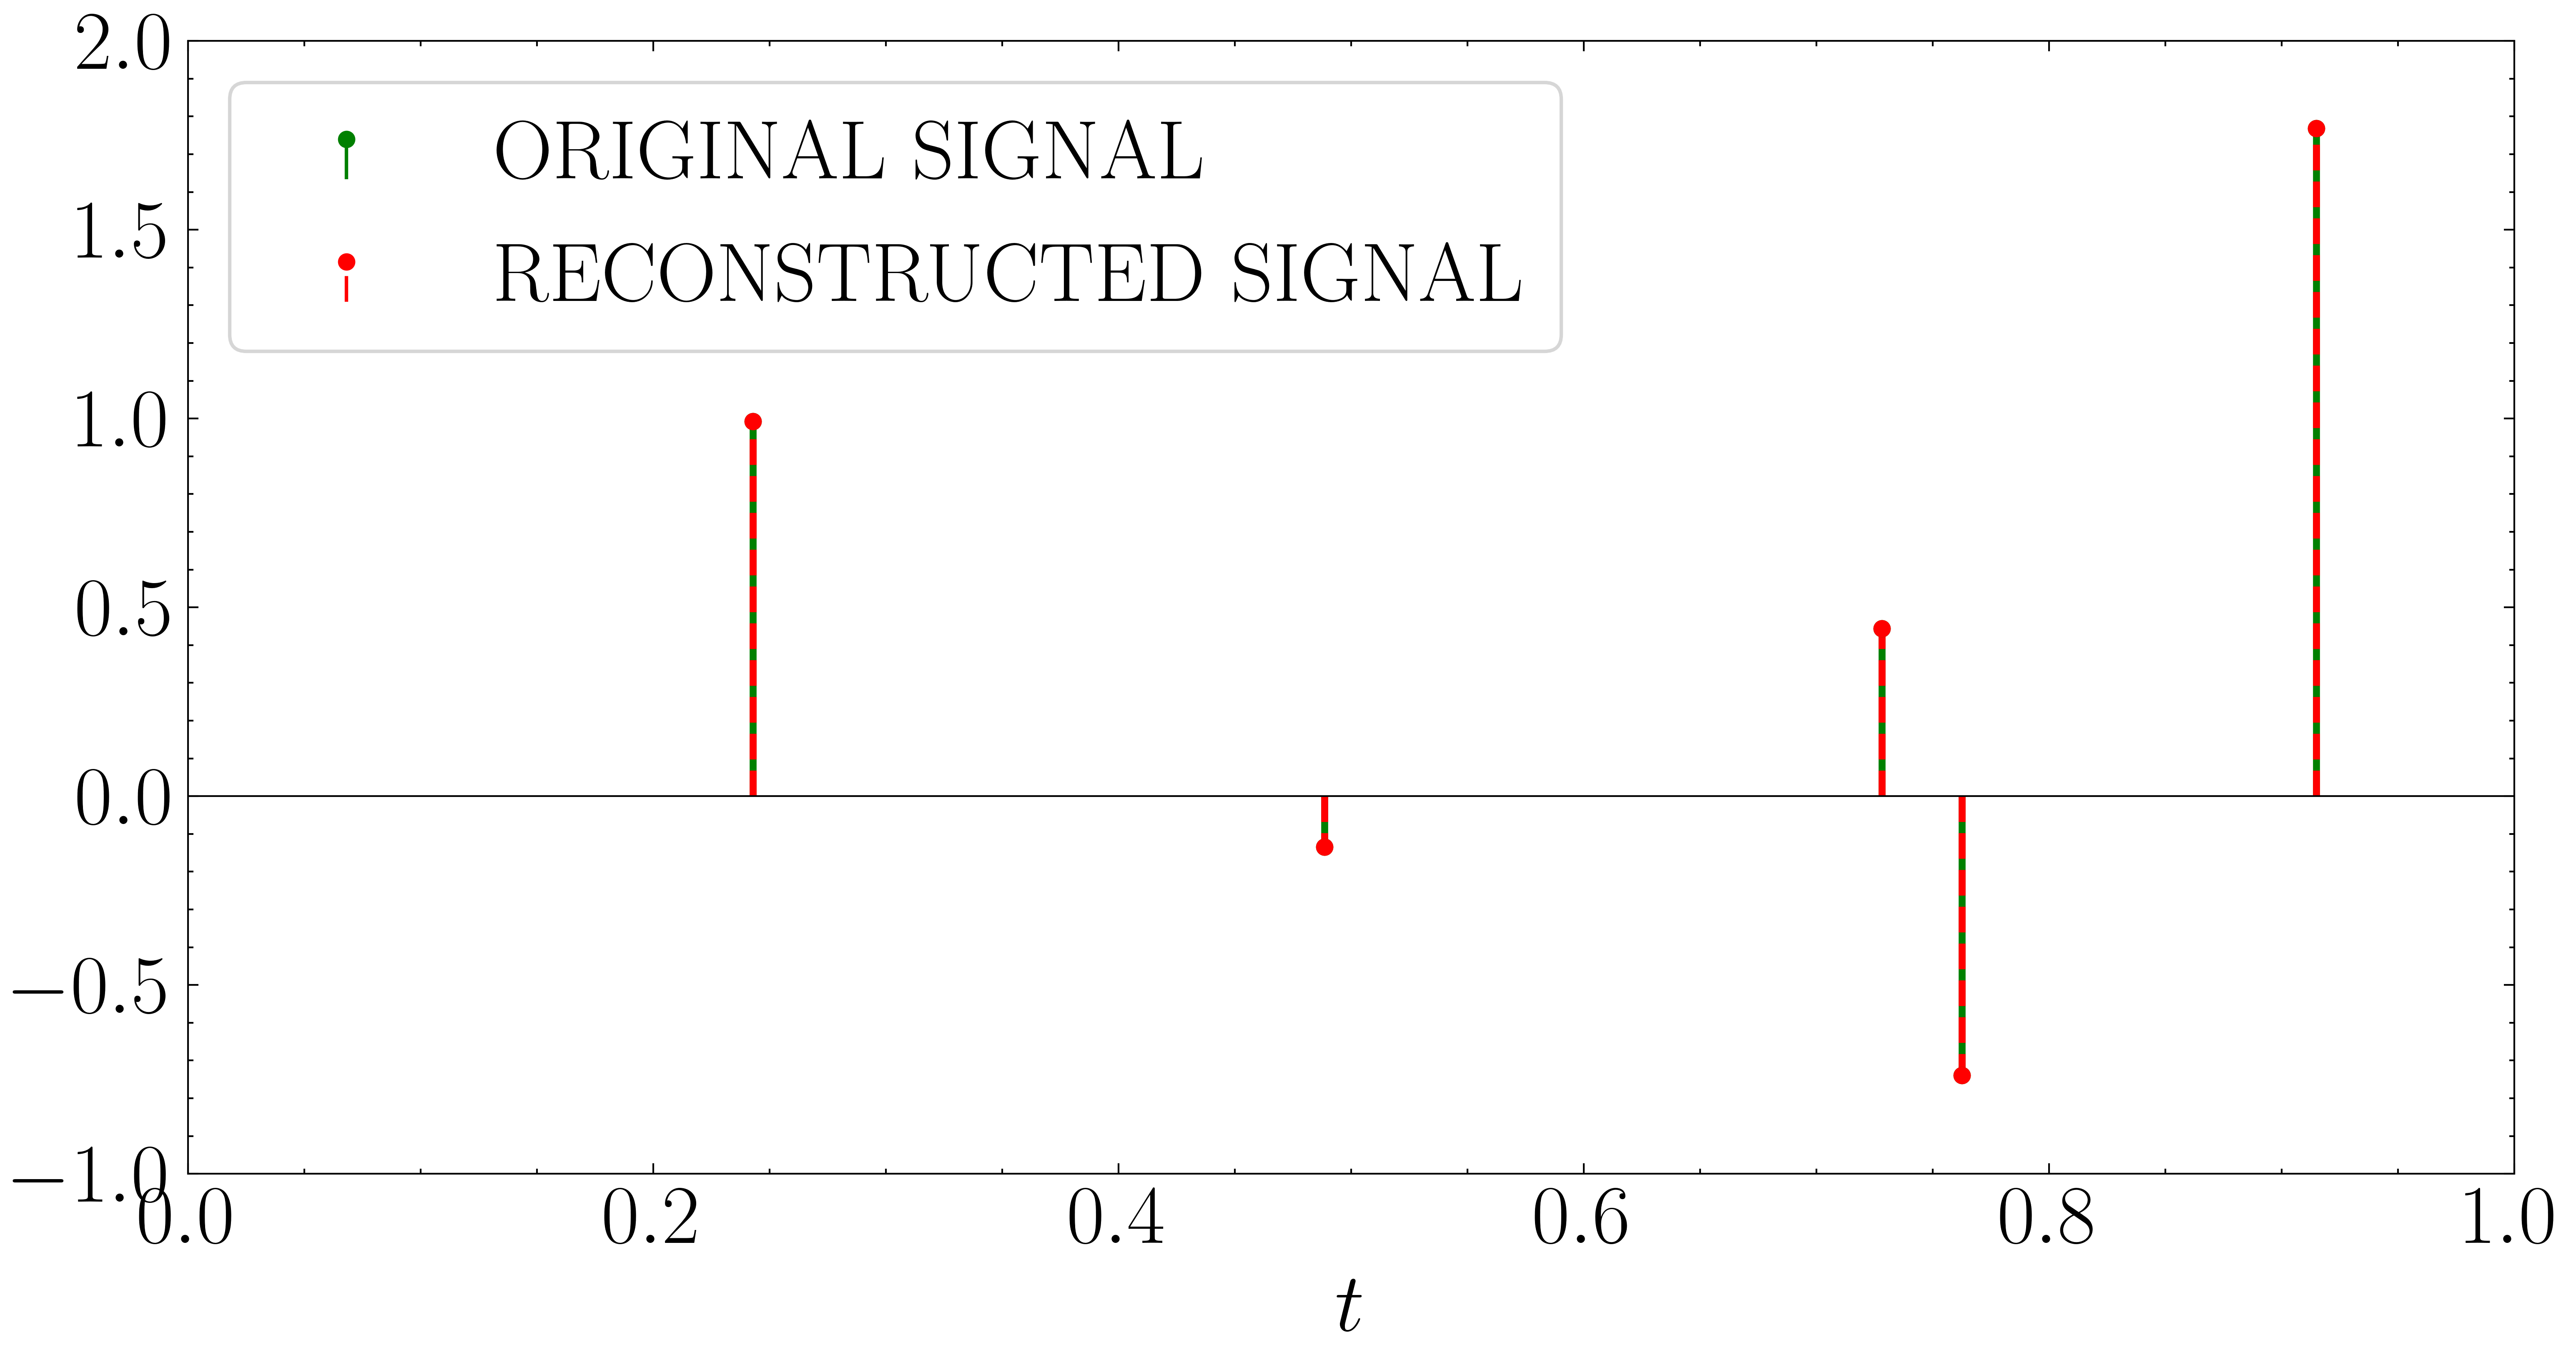

In [10]:
# %% PLOT RECONSTRUCTION

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_diracs(tk, ak, ax=ax, plot_colour='green',
    legend_label=r'ORIGINAL SIGNAL', show=False)
fri_utils.plot_signal(t_continuous, np.zeros(len(t_continuous)), ax=ax,
    plot_colour='black', line_width=0.5, show=False)
fri_utils.plot_diracs(tk_estimate, ak_estimate, ax=ax, plot_colour='red',
    line_style='--', legend_label=r'RECONSTRUCTED SIGNAL',
    xlimits=[0,TAU], ylimits=[-1,2], xaxis_label=r'$t$', show=True,
    save=path+'sincPronyDiracReconstruction')